In [1]:
using Statistics
using Flux, Flux.Optimise
using Images: channelview
using Flux.Data: DataLoader
using Metalhead: trainimgs, valimgs
using Images.ImageCore
using Flux: onehotbatch, onecold, flatten
using Base.Iterators: partition
using CUDA

In [2]:
Flux.use_cuda[]

true

# 1. Load Data

In [3]:
# The image will give us an idea of what we are dealing with.
# ![title](https://pytorch.org/tutorials/_images/cifar10.png)

Metalhead.download(CIFAR10)
X = trainimgs(CIFAR10)
labels = onehotbatch([X[i].ground_truth.class for i in 1:50000],1:10)

10×50000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  1  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅

,,,,,,,,,

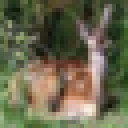
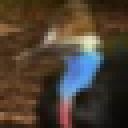
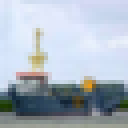
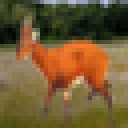
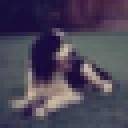
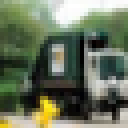
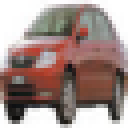
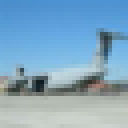
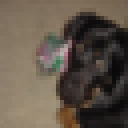
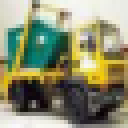

In [4]:
image(x) = x.img # handy for use later
ground_truth(x) = x.ground_truth
image.(X[rand(1:end, 10)])

In [5]:
getarray(X) = float.(permutedims(channelview(X), (3, 2, 1)))
imgs = [getarray(X[i].img) for i in 1:50000];

In [6]:
train = ([(cat(imgs[i]..., dims = 4), labels[:,i]) for i in partition(1:49000, 1000)]) |> gpu
valset = 49001:50000
valX = cat(imgs[valset]..., dims = 4) |> gpu
valY = labels[:, valset] |> gpu;

# 2. Define Model

In [70]:
m = Chain(
  Conv((5,5), 3=>16, relu),
  MaxPool((2,2)),
  Conv((5,5), 16=>8, relu),
  MaxPool((2,2)),
  flatten,
  Dense(200, 120),
  Dense(120, 84),
  Dense(84, 10),
  softmax) |> gpu

Chain(
  Conv((5, 5), 3 => 16, relu),          # 1_216 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 16 => 8, relu),          # 3_208 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(200, 120),                      # 24_120 parameters
  Dense(120, 84),                       # 10_164 parameters
  Dense(84, 10),                        # 850 parameters
  NNlib.softmax,
)                   # Total: 10 arrays, 39_558 parameters, 1.453 KiB.

# 3. Define Loss Function

In [72]:
using Flux: Momentum

loss(x, y) = Flux.Losses.crossentropy(m(x), y)
opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}())

In [73]:
accuracy(x, y) = mean(onecold(m(x), 1:10) .== onecold(y, 1:10))

accuracy (generic function with 1 method)

# 4. Train Network

In [1]:
epochs = 10

for epoch = 1:epochs
  for d in train
    gs = gradient(params(m)) do
      l = loss(d...)
    end
    update!(opt, params(m), gs)
  end
  @show accuracy(valX, valY)
end

LoadError: UndefVarError: train not defined

# 5. Test Network

,,,,,,,,,

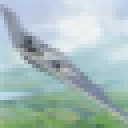
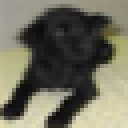
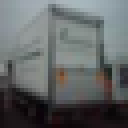
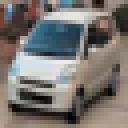
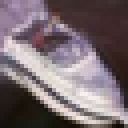
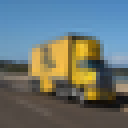
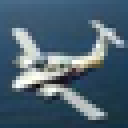
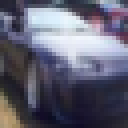
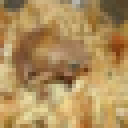
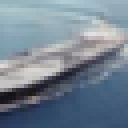

In [12]:
valset = valimgs(CIFAR10)
valimg = [getarray(valset[i].img) for i in 1:10000]
labels = onehotbatch([valset[i].ground_truth.class for i in 1:10000],1:10)
test = gpu.([(cat(valimg[i]..., dims = 4), labels[:,i]) for i in partition(1:10000, 1000)])

# Next, display some of the images from the test set.

ids = rand(1:10000, 10)
image.(valset[ids])

In [13]:
rand_test = getarray.(image.(valset[ids]))
rand_test = cat(rand_test..., dims = 4) |> gpu
rand_truth = ground_truth.(valset[ids])
m(rand_test)

10×10 CuArray{Float32, 2}:
 0.56705     0.00102234   0.0634348  0.00214601   …  0.00667273   0.239596
 0.00608763  0.00422836   0.0278883  0.953437        0.000649269  0.0176103
 0.10612     0.00829392   0.0962421  0.000239316     0.137496     0.00226527
 0.0341481   0.104693     0.0712176  0.000483215     0.0809528    0.000301508
 0.0448538   0.00827162   0.0355317  8.7218f-5       0.271483     0.000751445
 0.0471823   0.0466962    0.028821   0.000198101  …  0.155886     0.000117175
 0.00108683  0.745184     0.0552685  0.000123489     0.225286     4.25312f-5
 0.0203477   0.0388054    0.024605   0.000107698     0.118307     0.000201489
 0.166596    0.000320122  0.396278   0.00180632      0.000898965  0.723361
 0.00652837  0.0424843    0.200713   0.041372        0.00236869   0.0157532

In [14]:
accuracy(test[1]...)

0.447

In [15]:

class_correct = zeros(10)
class_total = zeros(10)
for i in 1:10
  preds = m(test[i][1])
  lab = test[i][2]
  for j = 1:1000
    pred_class = findmax(preds[:, j])[2]
    actual_class = findmax(lab[:, j])[2]
    if pred_class == actual_class
      class_correct[pred_class] += 1
    end
    class_total[actual_class] += 1
  end
end

class_correct ./ class_total


┌ Warning: Performing scalar indexing on task Task (runnable) @0x00007f68f40168c0.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArrays /home/john/.julia/packages/GPUArrays/8dzSJ/src/host/indexing.jl:56


10-element Vector{Float64}:
 0.5
 0.489
 0.188
 0.203
 0.308
 0.557
 0.583
 0.521
 0.555
 0.636